In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install turicreate
import turicreate as tc

     |████████████████████████████████| 91.9 MB 49.1 MB/s eta 0:00:01
     |████████████████████████████████| 86.3 MB 96 kB/s s eta 0:00:01
     |████████████████████████████████| 322 kB 40.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.5 MB 46.7 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 3.8 MB/s  eta 0:00:01
     |████████████████████████████████| 449 kB 47.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 47.6 MB/s eta 0:00:01
  Created wheel for resampy: filename=resampy-0.2.1-py3-none-any.whl size=320848 sha256=0efd0028916ed3acdc51a945c8ee79b9e5242bfadddd29b9980a23a338fcee36
  Stored in directory: /root/.cache/pip/wheels/71/74/53/d5ceb7c5ee7a168c7d106041863e71ac3273f4a4677743a284
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7539 sha256=18806a158a8d52f2b4a8e16a86ce997210ce3dc337273d6133356c1c94164491
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Succ

  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
  Attempting uninstall: resampy
    Found existing installation: resampy 0.2.2
    Uninstalling resampy-0.2.2:
      Successfully uninstalled resampy-0.2.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

tensorflow-probability 0.11.0 requires gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
librosa 0.8.0 requires resampy>=0.2.2, but you'll have resampy 0.2.1 which is incompatible.
You should cons

In [2]:
sales=tc.SFrame('../input/house-data')

# Predicting house prices using k-nearest neighbors regression
We will implement k-nearest neighbors regression. 

Find the k-nearest neighbors of a given query input
Predict the output for the query input using the k-nearest neighbors
Choose the best value of k using a validation set

In [3]:
import numpy as np # note this allows us to refer to numpy as np instead

In [4]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame
    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists
    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]
    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()
    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]
    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()
    return(feature_matrix, output_array)

In [5]:
def normalize_features(feature_matrix):
    norms = np.linalg.norm(feature_matrix, axis=0)
    normalized_features = feature_matrix/norms
    return (normalized_features, norms)

In [6]:
(train_and_validation, test) = sales.random_split(.8, seed=1) # initial train/test split
(train, validation) = train_and_validation.random_split(.8, seed=1) # split training set into training and validation sets

In [7]:
feature_list = ['bedrooms',  
                'bathrooms',  
                'sqft_living',  
                'sqft_lot',  
                'floors',
                'waterfront',  
                'view',  
                'condition',  
                'grade',  
                'sqft_above',  
                'sqft_basement',
                'yr_built',  
                'yr_renovated',  
                'lat',  
                'long',  
                'sqft_living15',  
                'sqft_lot15']
features_train, output_train = get_numpy_data(train, feature_list, 'price')
features_test, output_test = get_numpy_data(test, feature_list, 'price')
features_valid, output_valid = get_numpy_data(validation, feature_list, 'price')

In [8]:
features_train, norms = normalize_features(features_train) # normalize training set features (columns)
features_test = features_test / norms # normalize test set by training set norms
features_valid = features_valid / norms # normalize validation set by training set norms

# Compute a single distance
To start, let's just explore computing the "distance" between two given houses. We will take our query house to be the first house of the test set and look at the distance between this house and the 10th house of the training set.

To see the features associated with the query house, print the first row (index 0) of the test feature matrix. You should get an 18-dimensional vector whose components are between 0 and 1.

In [10]:
print (features_test[0])

[ 0.00850979  0.00732466  0.00377192  0.00666177  0.00145774  0.00535787
  0.          0.          0.00733742  0.00768814  0.00454217  0.01166471
  0.00846092  0.          0.00850116 -0.00851828  0.00721359  0.00229411]


In [12]:
print (features_train[9])

[ 0.00850979  0.00732466  0.00660085  0.00512732  0.00188902  0.00535787
  0.          0.          0.00978323  0.00768814  0.00592645  0.
  0.0085343   0.          0.00851912 -0.00849796  0.00555204  0.00288651]


In [14]:
euclidean_distance = np.sqrt(np.sum((features_train[9] - features_test[0])**2))
print (euclidean_distance)

0.012554872936173524


# Compute multiple distances
Of course, to do nearest neighbor regression, we need to compute the distance between our query house and all houses in the training set.

To visualize this nearest-neighbor search, let's first compute the distance from our query house (features_test[0]) to the first 10 houses of the training set (features_train[0:10]) and then search for the nearest neighbor within this small set of houses. Through restricting ourselves to a small set of houses to begin with, we can visually scan the list of 10 distances to verify that our code for finding the nearest neighbor is working.

In [15]:
dist_dict = {}
for i in range(0,10):
    dist_dict[i] = np.sqrt(np.sum((features_train[i] - features_test[0])**2))
    print (i, np.sqrt(np.sum((features_train[i] - features_test[0])**2)))

0 0.012050533229212231
1 0.04280162009764651
2 0.013181777574725061
3 0.009971445263184053
4 0.012614720078862605
5 0.04346163898382663
6 0.014105182828657609
7 0.012147374698947692
8 0.012697609428910614
9 0.012554872936173524


In [16]:
print (min(dist_dict.items(), key=lambda x: x[1]) )

(3, 0.009971445263184053)


It is computationally inefficient to loop over computing distances to all houses in our training dataset. Fortunately, many of the Numpy functions can be vectorized, applying the same operation over multiple values or vectors. We now walk through this process

In [18]:
print (features_train[0:3] - features_test[0])

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.24554083e-03
  -3.55166179e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  5.62363556e-04 -1.16647063e-02
  -2.15839686e-05  0.00000000e+00 -1.89630521e-07  5.55783344e-06
  -1.78313579e-03 -6.96460868e-04]
 [ 0.00000000e+00  0.00000000e+00  4.71489397e-03  2.95662876e-03
  -4.44933455e-05  5.35786902e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  4.84497833e-03 -5.27308643e-03
  -3.88511434e-05  4.14833088e-02  3.73469101e-05  1.23472293e-06
  -3.64732320e-04 -1.34032664e-04]
 [ 0.00000000e+00 -2.44155295e-03  0.00000000e+00 -3.77999373e-03
   4.93720018e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.09830575e-03 -1.21124458e-03 -1.16647063e-02
  -1.16553430e-04  0.00000000e+00  4.03714421e-05  7.19965975e-06
   3.80942645e-03 -1.44212360e-05]]


In [19]:
# verify that vectorization works
results = features_train[0:3] - features_test[0]
print (results[0] - (features_train[0]-features_test[0]))
# should print all 0's if results[0] == (features_train[0]-features_test[0])
print (results[1] - (features_train[1]-features_test[0]))
# should print all 0's if results[1] == (features_train[1]-features_test[0])
print (results[2] - (features_train[2]-features_test[0]))
# should print all 0's if results[2] == (features_train[2]-features_test[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Perform 1-nearest neighbor regression
Now that we have the element-wise differences, we compute the Euclidean distances between our query house and all of the training houses. First, write a single-line expression to define a variable diff such that diff[i] gives the element-wise difference between the features of the query house and the i-th training house.

In [20]:
diff = features_train - features_test[0]

The next step in computing the Euclidean distances is to take these feature-by-feature differences in diff, square each, and take the sum over feature indices. That is, compute the sum of square feature differences for each training house (row in diff).

By default, np.sum sums up everything in the matrix and returns a single number. To instead sum only over a row or column, we need to specifiy the axis parameter described in the np.sum documentation. In particular, axis=1 computes the sum across each row.
Below, we compute this sum of square feature differences for all training houses and verify that the output for the 16th house in the training set is equivalent to having examined only the 16th row of diff and computing the sum of squares on that row alone.

In [22]:
print (np.sum(diff**2, axis=1)[15]) # take sum of squares across each row, and print the 16th sum
print (np.sum(diff[15]**2)) # print the sum of squares for the 16th row -- should be same as above

0.0001580004719698541
0.0001580004719698541


In [23]:
distances = np.sqrt(np.sum(diff**2, axis=1))


In [24]:
def compute_distances(train_matrix, query_vector):
    diff = train_matrix - query_vector
    distances = np.sqrt(np.sum(diff**2, axis=1))
    return distances

# Perform k-nearest neighbor regression
For k-nearest neighbors, we need to find a set of k houses in the training set closest to a given query house. We then make predictions based on these k nearest neighbors.

Fetch k-nearest neighbors
Using the functions above, implement a function that takes in 
the value of k;
the feature matrix for the training houses; and
the feature vector of the query house
and returns the indices of the k closest training houses. For instance, with 2-nearest neighbor, a return value of [5, 10] would indicate that the 6th and 11th training houses are closest to the query house.

In [25]:
def compute_k_nearest_neighbors(k, features_matrix, feature_vector):
    distances = compute_distances(features_matrix, feature_vector)
    return np.argsort(distances, axis = 0)[:k]

# Make a single prediction by averaging k nearest neighbor outputs
Now that we know how to find the k-nearest neighbors, write a function that predicts the value of a given query house. For simplicity, take the average of the prices of the k nearest neighbors in the training set. The function should have the following parameters:

the value of k;
the feature matrix for the training houses;
the output values (prices) of the training houses; and
the feature vector of the query house, whose price we are predicting.
The function should return a predicted value of the query house.

In [26]:
def compute_distances_k_avg(k, features_matrix, output_values, feature_vector):
    k_neigbors = compute_k_nearest_neighbors(k, features_matrix, feature_vector)
    avg_value = np.mean(output_values[k_neigbors])
    return avg_value 

# Make multiple predictions
Write a function to predict the value of each and every house in a query set. (The query set can be any subset of the dataset, be it the test set or validation set.) The idea is to have a loop where we take each house in the query set as the query house and make a prediction for that specific house. The new function should take the following parameters:

the value of k;
the feature matrix for the training houses;
the output values (prices) of the training houses; and
the feature matrix for the query set.
The function should return a set of predicted values, one for each house in the query set.

In [28]:
def compute_distances_k_all(k, features_matrix, output_values, feature_vector):
    num_of_rows = feature_vector.shape[0]
    predicted_values = []
    for i in range(num_of_rows):
        avg_value = compute_distances_k_avg(k, features_train, output_train, features_test[i])
        predicted_values.append(avg_value)
    return predicted_values

# Choosing the best value of k using a validation set
There remains a question of choosing the value of k to use in making predictions. Here, we use a validation set to choose this value. Write a loop that does the following:

For k in [1, 2, ..., 15]:
Makes predictions for each house in the VALIDATION set using the k-nearest neighbors from the TRAINING set.
Computes the RSS for these predictions on the VALIDATION set
Stores the RSS computed above in rss_all
Report which k produced the lowest RSS on VALIDATION set.

In [30]:
rss_all = []
for k in range(1,16):    
    predict_value = compute_distances_k_all(k, features_train, output_train, features_valid)
    residual = (output_valid - predict_value)
    rss = sum(residual**2)
    rss_all.append(rss)

In [31]:
print (rss_all)

[869632055382351.0, 783388926458278.0, 744972801667744.1, 728114904077459.5, 714890611633347.5, 708698348604031.9, 703464816169964.4, 696916302041427.8, 691300580941176.5, 683928765218381.1, 680369724089891.1, 679102504467732.6, 678800251541266.8, 676756327081701.1, 675545042988865.6]


In [32]:
print (rss_all.index(min(rss_all)))

14


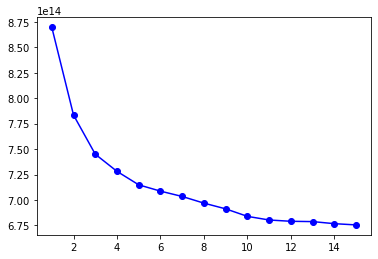

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

kvals = range(1, 16)
plt.plot(kvals, rss_all,'bo-')

# RSS on the TEST data using the value of k found above

In [34]:
predict_value = compute_distances_k_all(14, features_train, output_train, features_test)
residual = (output_test - predict_value)
rss = sum(residual**2)
print (rss)

223023963137738.9
